<a href="https://colab.research.google.com/github/dbtmddn41/deep_learning/blob/main/kaggle/cactus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = '딥러닝/kaggle/cactus\ identification'

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/딥러닝/kaggle/cactus identification


In [ ]:
!mkdir -p ~/.kaggle
!cp ../kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c aerial-cactus-identification

!unzip -o aerial-cactus-identification.zip
!unzip -qq -o train.zip
!unzip -qq -o test.zip

aerial-cactus-identification.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  aerial-cactus-identification.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.csv               
  inflating: train.zip               


In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers

# 데이터 둘러보기

In [ ]:
labels = pd.read_csv('train.csv')
submission = pd.read_csv('sample_submission.csv')
labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [ ]:
submission.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


([<matplotlib.patches.Wedge at 0x7fab205e14e0>,
 [Text(-0.7793519565739234, 0.7762799287527649, 'O'),
  Text(0.7793519929142085, -0.776279892268666, 'X')],
 [Text(-0.42510106722213997, 0.42342541568332626, '75.1%'),
  Text(0.4251010870441137, -0.42342539578290866, '24.9%')])

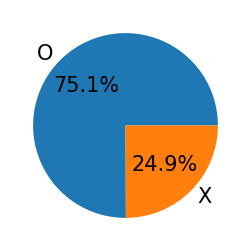

In [ ]:
mpl.rc('font', size=15)
plt.figure(figsize=(3,3))

label = ['O', 'X']
plt.pie(labels['has_cactus'].value_counts(), labels=label, autopct="%.1f%%")

In [ ]:
import os

train_num = len(os.listdir('train/'))
test_num = len(os.listdir('test/'))
print(f'훈련데이터 개수: {train_num}')
print(f'테스트데이터 개수: {test_num}')

훈련데이터 개수: 17500
테스트데이터 개수: 4000


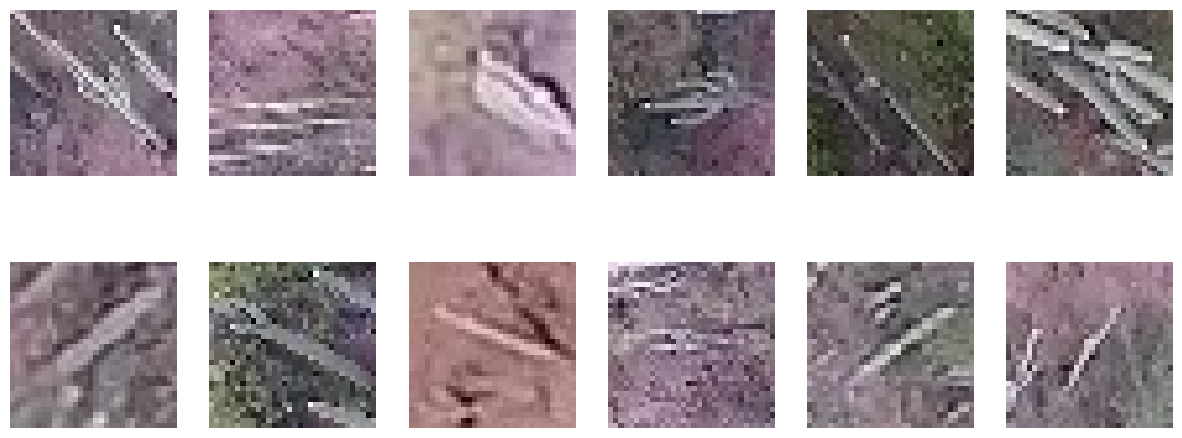

In [ ]:
from matplotlib import gridspec
import cv2

mpl.rc('font', size=7)
plt.figure(figsize=(15, 6))
grid = gridspec.GridSpec(2, 6)

last_has_cactus_img_name = labels[labels['has_cactus']==1]['id'][-12:]

for idx, img_name in enumerate(last_has_cactus_img_name):
    img_path = 'train/' + img_name
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(grid[idx])
    ax.imshow(image)
    ax.axis('off')

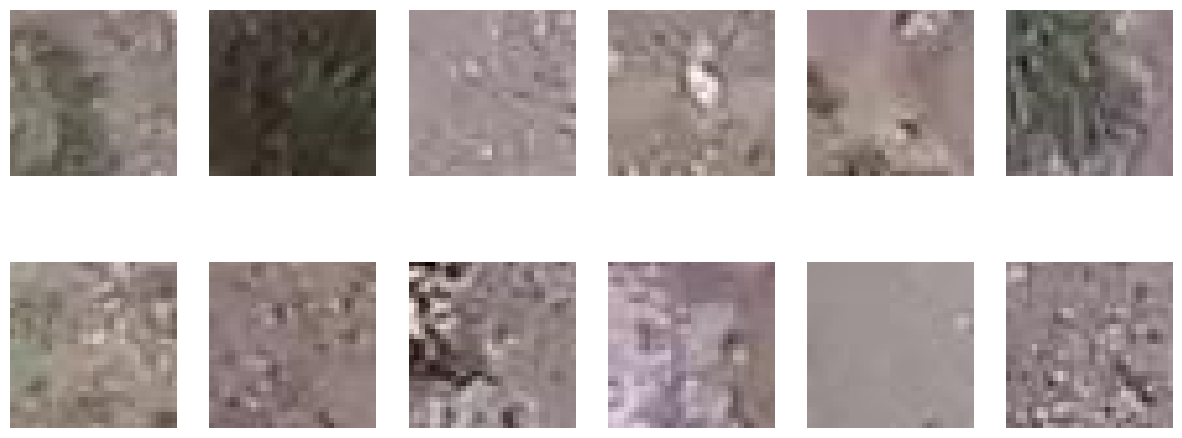

In [ ]:
plt.figure(figsize=(15, 6))
grid = gridspec.GridSpec(2, 6)
last_hasnot_cactus_img_name = labels[labels['has_cactus']==0]['id'][-12:]

for idx, img_name in enumerate(last_hasnot_cactus_img_name):
    img_path = 'train/' + img_name
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(grid[idx])
    ax.imshow(image)
    ax.axis('off')

In [ ]:
image.shape

(32, 32, 3)

In [ ]:
import os, shutil, pathlib
from sklearn.model_selection import train_test_split

if 'cactus_train' in os.listdir():
    shutil.rmtree('cactus_train/')
origin_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cactus_train")
def make_subset(subset_name, df):
    for i, category in enumerate(('hasnot', 'has')):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = df[df['has_cactus']==i]['id']
        for fname in fnames:
            shutil.copyfile(src=origin_dir/fname, dst=dir/fname)

train_data, validation_data = train_test_split(labels, test_size=0.2, random_state=42, stratify=labels['has_cactus'])
make_subset("train", train_data)
make_subset("validation", validation_data)

In [ ]:
print(train_data.describe())
print(validation_data.describe())

         has_cactus
count  14000.000000
mean       0.750643
std        0.432656
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
        has_cactus
count  3500.000000
mean      0.750571
std       0.432744
min       0.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       1.000000


In [ ]:
if 'cactus_test' in os.listdir():
    shutil.rmtree('cactus_test/')

os.mkdir('cactus_test/')
os.mkdir('cactus_test/test')
for fname in os.listdir('test/'):
    shutil.copyfile('test/' + fname, 'cactus_test/test/'+fname)

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(new_base_dir / 'train', image_size=(32, 32), batch_size=3500)
val_dataset = image_dataset_from_directory(new_base_dir / 'validation', image_size=(32, 32), batch_size=3500)
test_dataset = image_dataset_from_directory('cactus_test', image_size=(32, 32), batch_size=3500)


Found 14000 files belonging to 2 classes.
Found 3500 files belonging to 2 classes.
Found 4000 files belonging to 1 classes.


In [ ]:
i=1
plt.figure(figsize=(15, 5))
for image, target in train_dataset.take(5):
    image = image[0].numpy().astype(np.uint8)
    ax = plt.subplot(2,5,i)
    ax.imshow(image)
    print(target)
    i+=1

for image, target in val_dataset.take(5):
    image = image[0].numpy().astype(np.uint8)
    ax = plt.subplot(2,5,i)
    ax.imshow(image)
    print(target)
    i+=1

KeyboardInterrupt: ignored

<Figure size 1500x500 with 0 Axes>

# 모델 학습하기

In [ ]:
data_augment = keras.Sequential([
      layers.RandomFlip('horizontal_and_vertical'),
      layers.RandomRotation(0.1),
      layers.RandomZoom(0.1)
])

In [ ]:
inputs = keras.Input(shape=(32,32,3))
x = layers.Rescaling(1./255)(inputs)
x = data_augment(x)

x = layers.Conv2D(filters=16, kernel_size=3, padding='same', use_bias=False)(x)
# x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=2, padding='same')(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(filters=32, kernel_size=3, padding='same', use_bias=False)(x)
# x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=2, padding='same')(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(filters=64, kernel_size=3, padding='same', use_bias=False)(x)
# x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=2, padding='same')(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

my_model = keras.Model(inputs, outputs)
my_model.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_21 (Rescaling)    (None, 32, 32, 3)         0         
                                                                 
 sequential_5 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv2d_59 (Conv2D)          (None, 32, 32, 16)        432       
                                                                 
 re_lu_59 (ReLU)             (None, 32, 32, 16)        0         
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                          

In [ ]:
my_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = [keras.callbacks.ModelCheckpoint(filepath='my_model.keras', save_best_only=True, monitor='val_loss'),
             keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30)]

history = my_model.fit(train_dataset.cache().prefetch(tf.data.AUTOTUNE), epochs=400, validation_data=val_dataset.cache().prefetch(tf.data.AUTOTUNE), callbacks=callbacks)

Epoch 1/400
4/4 [==============================] - 13s 861ms/step - loss: 0.6774 - accuracy: 0.5964 - val_loss: 0.6226 - val_accuracy: 0.7506
Epoch 2/400
4/4 [==============================] - 0s 74ms/step - loss: 0.5808 - accuracy: 0.7506 - val_loss: 0.5553 - val_accuracy: 0.7506
Epoch 3/400
4/4 [==============================] - 0s 48ms/step - loss: 0.5818 - accuracy: 0.7506 - val_loss: 0.5668 - val_accuracy: 0.7506
Epoch 4/400
4/4 [==============================] - 0s 46ms/step - loss: 0.5665 - accuracy: 0.7506 - val_loss: 0.5850 - val_accuracy: 0.7506
Epoch 5/400
4/4 [==============================] - 0s 47ms/step - loss: 0.5653 - accuracy: 0.7506 - val_loss: 0.5688 - val_accuracy: 0.7506
Epoch 6/400
4/4 [==============================] - 0s 59ms/step - loss: 0.5582 - accuracy: 0.7506 - val_loss: 0.5448 - val_accuracy: 0.7506
Epoch 7/400
4/4 [==============================] - 0s 47ms/step - loss: 0.5543 - accuracy: 0.7506 - val_loss: 0.5472 - val_accuracy: 0.7506
Epoch 8/400
4/4 [=

In [ ]:
def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss)+1)
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title("Training and Validation accuracy")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

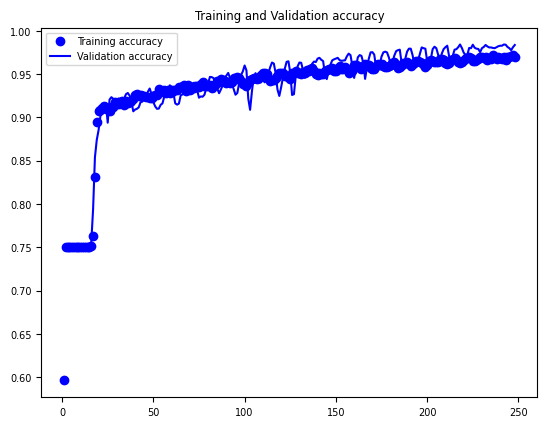

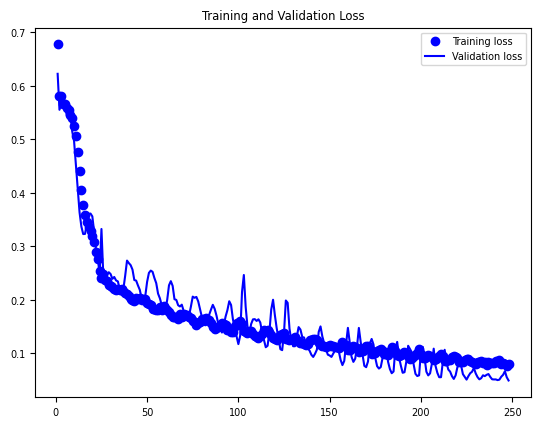

In [ ]:
plot_history(history)

In [ ]:
best_my_model = keras.models.load_model('my_model.keras')

best_my_model.evaluate(val_dataset)

1/1 [==============================] - 2s 2s/step - loss: 0.0495 - accuracy: 0.9837


[0.04949194937944412, 0.9837142825126648]

In [ ]:
test_pred = best_my_model.predict(test_dataset)

2/2 [==============================] - 3s 76ms/step


In [ ]:
submission['has_cactus'] = pd.DataFrame((test_pred<0.5).astype('float'))

In [ ]:
submission.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,1.0
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.0
2,001ee6d8564003107853118ab87df407.jpg,1.0
3,002e175c3c1e060769475f52182583d0.jpg,1.0
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,1.0


In [ ]:
submission.to_csv('submission.csv')